In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
warnings.filterwarnings("ignore")


##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf


In [2]:
##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_transformations = dir_cur.joinpath("transformations")


##  SETUP FILES

fp_data_base = dir_data.joinpath("sisepuede_inputs_iran.csv")


##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

In [3]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

#  Let's try building transformations using this


In [11]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs,
)


##  Instantiate some transformations CAREFUL NOT TO OVERWRITE EXISTING TRANSFORMATIONS!!

In [157]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--
- go to `dir_transformers` and edit config files and `strategy_definitions.csv`
- then, go to next cell

In [12]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table




In [13]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")



Strategies defined at /Users/usuario/git/sisepuede_region_nbs/iran/transformations initialized in 1.97 seconds


In [59]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:CONSTRAINED,Constrained Climate Action,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0
70,6004,PFLO:TECHNOLOGICAL_ADOPTION,Technology Adoption Scenario,NaN,TX:AGRC:DEC_CH4_RICE_LOW|TX:AGRC:DEC_LOSSES_SU...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [390]:
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = [0, 6003, 6004, 6005],
)



0

# Finally, load SISEPUEDE so that we can run it

In [18]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    id_str = "sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = ["iran"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-11-04 18:12:34,442 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-11-04 18:12:34,444 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-11-04 18:12:34,444 - INFO - 	Setting export engine to 'csv'.
2024-11-04 18:12:34,444 - DEBUG - Trying to get columns for ANALYSIS_METADATA from table at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-04T09;23;26.721580/sisepuede_run_2024-11-04T09;23;26.721580_output_database/ANALYSIS_METADATA.csv.
2024-11-04 18:12:34,447 - INFO - Table ANALYSIS_METADATA found at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-11-04T09;23;26.721580/sisepuede_run_2024-11-04T09;23;26.721580_output_database/ANALYSIS_METADATA.csv; it will not be replaced.
2024-11-04 18:12:34,447 - INFO - 	Columns successfully retrieved.
2024-11-04 18:12:34,448 - W

[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/pyjuliapkg/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Using Julia 1.11.1 at /Users/usuario/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/bin/julia
[juliapkg] Using Julia project at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="Cbc", uuid="9961bab8-2fa3-5c5a-9d89-47fab24efd76"), Pkg.PackageSpec(name="Clp", uuid="e2554f3b-3117-50c0-817c-e040a3ddf72d"), Pkg.PackageSpec(name="DataFrames", uuid="a93c6f00-e57d-5684-b7b6

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed SentinelArrays ─ v1.4.7
   Installed GLPK_jll ─────── v5.0.1+1
   Installed HiGHS ────────── v1.11.0
   Installed ForwardDiff ──── v0.10.37
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Project.toml`
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [a93c6f00] + DataFrames v1.7.0
  [60bf3e95] + GLPK v1.2.1
  [87dc4568] + HiGHS v1.11.0
  [b6b21f68] + Ipopt v1.6.7
  [4076af6c] + JuMP v1.23.3
  [a3c327a0] + NemoMod v2.0.0 `https://github.com/sei-international/NemoMod.jl.git#61e63e0`
⌅ [6099a3de] + PythonCall v0.9.22
  [0aa819cd] + SQLite v1.6.1
    Updating `/opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/julia/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [9961bab8] + Cbc v1.2.0
  [e2554f3b] + Clp v1.1.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + Co

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1337.1 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-11-04 18:13:54,832 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-11-04 18:13:54,846 - INFO - Successfully initialized SISEPUEDEModels.
2024-11-04 18:13:54,846 - WARNING - WARNING: re-initialization from analyis id requires addition coding to facilitate the re-generation 

In [392]:
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [0, 6003, 6004, 6005],
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2024-11-04 09:23:39,739 - INFO - 
***	STARTING REGION iran	***

2024-11-04 09:23:39,739 - INFO - 
***	STARTING REGION iran	***

2024-11-04 09:23:39,739 - INFO - 
***	STARTING REGION iran	***

2024-11-04 09:23:39,739 - INFO - 
***	STARTING REGION iran	***

2024-11-04 09:23:39,739 - INFO - 
***	STARTING REGION iran	***

2024-11-04 09:23:39,739 - INFO - 
***	STARTING REGION iran	***

2024-11-04 09:23:41,181 - INFO - Trying run primary_id = 0 in region iran
2024-11-04 09:23:41,181 - INFO - Trying run primary_id = 0 in region iran
2024-11-04 09:23:41,181 - INFO - Trying run primary_id = 0 in region iran
2024-11-04 09:23:41,181 - INFO - Trying run primary_id = 0 in region iran
2024-11-04 09:23:41,181 - INFO - Trying run primary_id = 0 in region iran
2024-11-04 09:23:41,181 - INFO - Trying run primary_id = 0 in region iran
2024-11-04 09:23:41,182 - INFO - Running AFOLU model
2024-11-04 09:23:41,182 - INFO - Running AFOLU model
2024-11-04 09:23:41,182 - INFO - Running AFOLU model
2024-11-04 09

2024-04-Nov 09:23:41.405 Opened SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-04-Nov 09:23:41.415 Added NEMO structure to SQLite database at /opt/miniconda3/envs/amber_is_your_energy/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-04-Nov 09:23:41.912 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-04 09:24:09,343 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:09,343 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:09,343 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:09,343 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:09,343 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:09,343 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:09,352 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:24:09,352 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:24:09,352 - INFO - EnergyProduction model run successfully co

2024-04-Nov 09:24:09.267 Finished modeling scenario.


2024-11-04 09:24:09,495 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:09,495 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:09,495 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:09,495 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:09,495 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:09,495 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:09,496 - INFO - Running CircularEconomy model
2024-11-04 09:24:09,496 - INFO - Running CircularEconomy model
2024-11-04 09:24:09,496 - INFO - Running CircularEconomy model
2024-11-04 09:24:09,496 - INFO - Running CircularEconomy model
2024-11-04 09:24:09,496 - INFO - Running CircularEconomy model
2024-11-04 09:24:09,496 - INFO - Running CircularEconomy model
2024-11-04 09:24:09,520 - INFO - CircularEconomy model run successfully completed
2024-11-04 09:24:09,520 - INFO - CircularEconomy model run successfully completed
2024-11-04 09:24:09,520 - 

2024-04-Nov 09:24:10.171 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-04 09:24:52,175 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:52,175 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:52,175 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:52,175 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:52,175 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:52,175 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:24:52,184 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:24:52,184 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:24:52,184 - INFO - EnergyProduction model run successfully co

2024-04-Nov 09:24:52.097 Finished modeling scenario.


2024-11-04 09:24:52,344 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:52,344 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:52,344 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:52,344 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:52,344 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:52,344 - INFO - AFOLU model run successfully completed
2024-11-04 09:24:52,346 - INFO - Running CircularEconomy model
2024-11-04 09:24:52,346 - INFO - Running CircularEconomy model
2024-11-04 09:24:52,346 - INFO - Running CircularEconomy model
2024-11-04 09:24:52,346 - INFO - Running CircularEconomy model
2024-11-04 09:24:52,346 - INFO - Running CircularEconomy model
2024-11-04 09:24:52,346 - INFO - Running CircularEconomy model
2024-11-04 09:24:52,373 - INFO - CircularEconomy model run successfully completed
2024-11-04 09:24:52,373 - INFO - CircularEconomy model run successfully completed
2024-11-04 09:24:52,373 - 

2024-04-Nov 09:24:53.140 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-04 09:25:31,190 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:25:31,190 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:25:31,190 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:25:31,190 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:25:31,190 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:25:31,190 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:25:31,200 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:25:31,200 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:25:31,200 - INFO - EnergyProduction model run successfully co

2024-04-Nov 09:25:31.113 Finished modeling scenario.


2024-11-04 09:25:31,353 - INFO - AFOLU model run successfully completed
2024-11-04 09:25:31,353 - INFO - AFOLU model run successfully completed
2024-11-04 09:25:31,353 - INFO - AFOLU model run successfully completed
2024-11-04 09:25:31,353 - INFO - AFOLU model run successfully completed
2024-11-04 09:25:31,353 - INFO - AFOLU model run successfully completed
2024-11-04 09:25:31,353 - INFO - AFOLU model run successfully completed
2024-11-04 09:25:31,354 - INFO - Running CircularEconomy model
2024-11-04 09:25:31,354 - INFO - Running CircularEconomy model
2024-11-04 09:25:31,354 - INFO - Running CircularEconomy model
2024-11-04 09:25:31,354 - INFO - Running CircularEconomy model
2024-11-04 09:25:31,354 - INFO - Running CircularEconomy model
2024-11-04 09:25:31,354 - INFO - Running CircularEconomy model
2024-11-04 09:25:31,381 - INFO - CircularEconomy model run successfully completed
2024-11-04 09:25:31,381 - INFO - CircularEconomy model run successfully completed
2024-11-04 09:25:31,381 - 

2024-04-Nov 09:25:32.039 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2024-04-Nov 09:26:12.237 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2024-11-04 09:26:12,314 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:26:12,314 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:26:12,314 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:26:12,314 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:26:12,314 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:26:12,314 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-11-04 09:26:12,324 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:26:12,324 - INFO - EnergyProduction model run successfully completed
2024-11-04 09:26:12,324 - INFO - EnergyProduction model run successfully co

{'iran': [0, 69069, 70070, 71071]}

In [173]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [41]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [61]:
(
    df_out
    .to_csv(
        dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
        index = None,
        encoding = "UTF-8",
    )
)

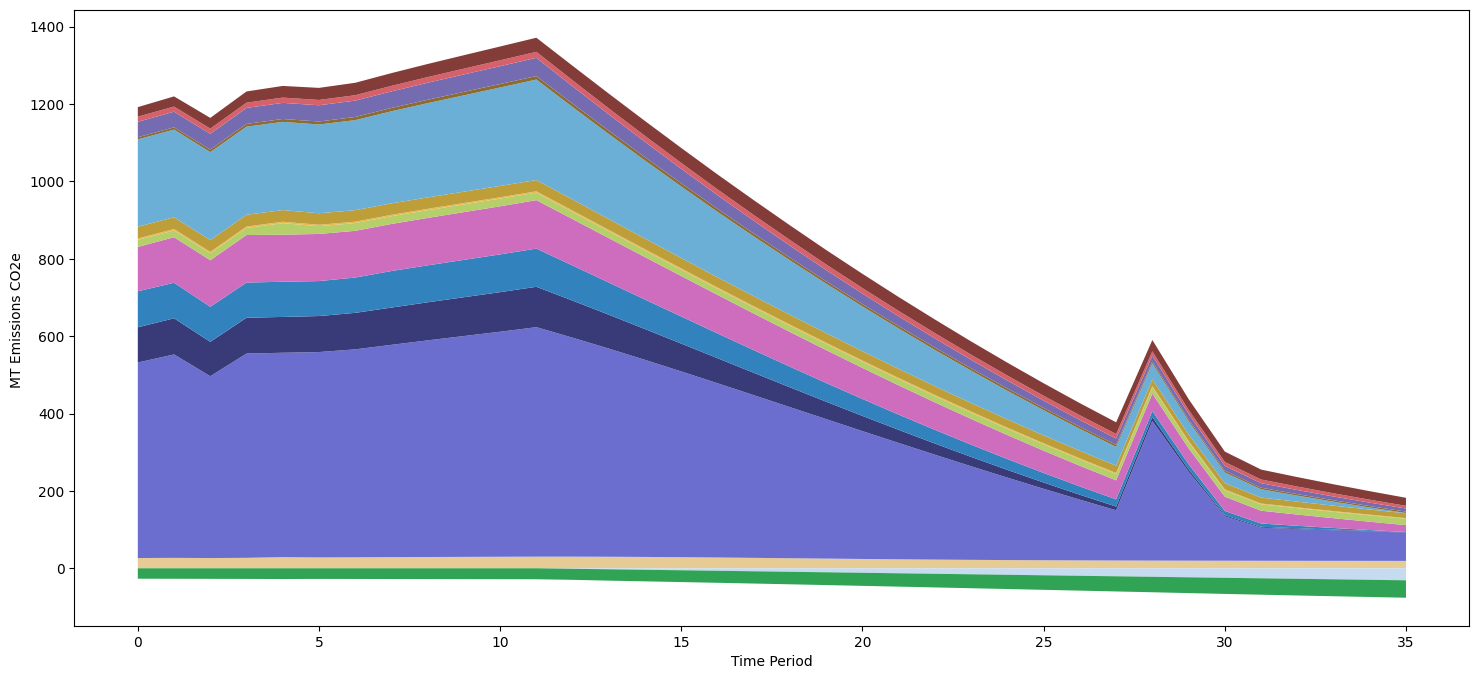

In [42]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



# Export Wide File

In [399]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

<Axes: >

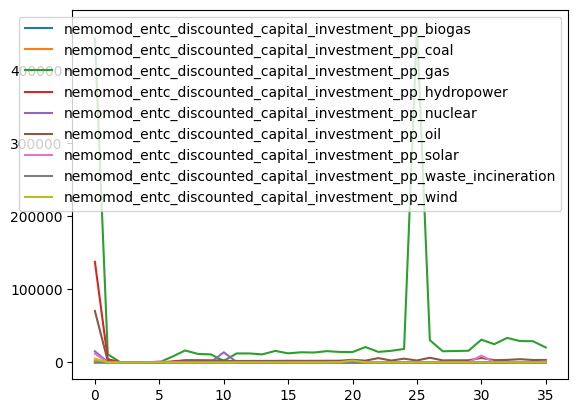

In [43]:
primary_id = 0

df_prim = df_out[
    df_out[
        ssp.key_primary
    ]
    .isin([primary_id])
]

df_in_cur = df_in[
    df_in[
        ssp.key_primary
    ]
    .isin([primary_id])
]


fields_plot = [
    x for x in df_prim.columns
    if "investment" in x
    and df_prim[x].max() > 0
]
(
    df_prim[fields_plot]
    .plot(
        legend = True,
    )
)




<Axes: >

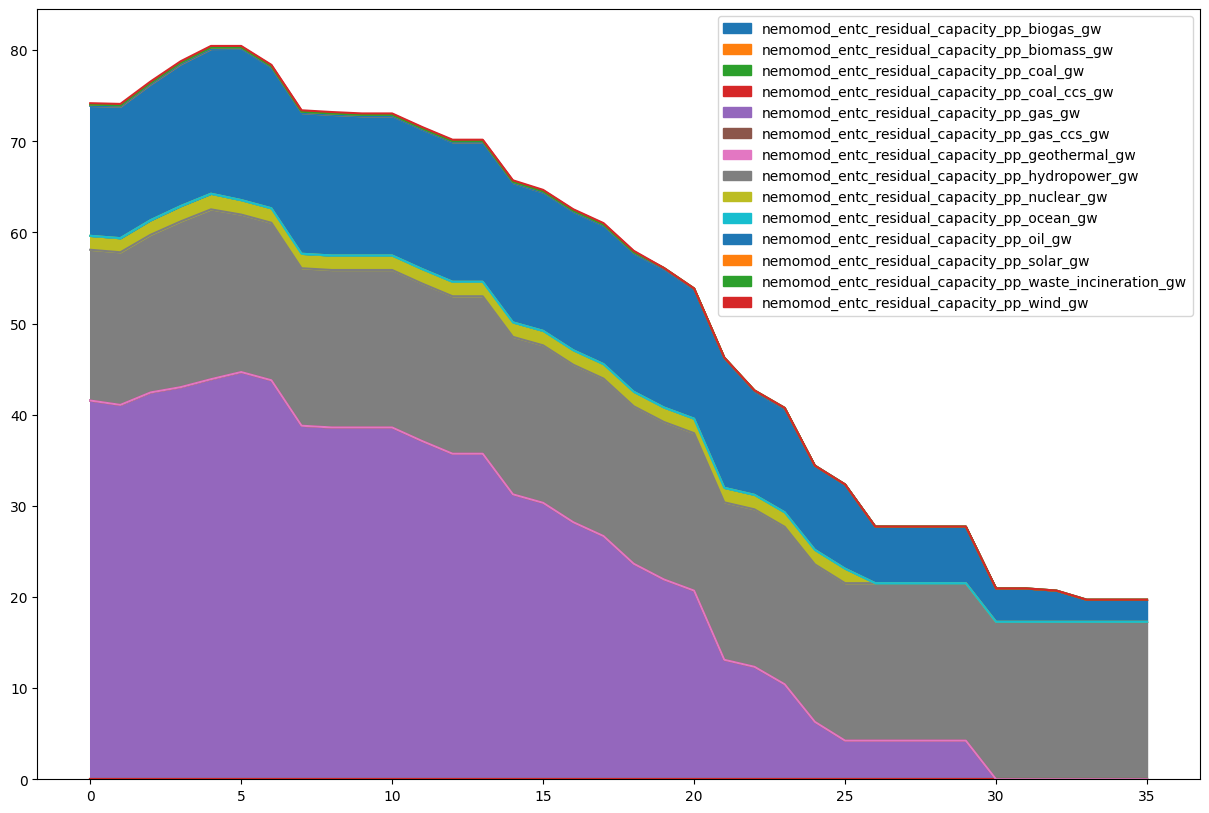

In [44]:


fig, ax = plt.subplots(figsize = (15, 10))
df_resid = matt.extract_model_variable(
    df_in_cur,
    "NemoMod ResidualCapacity"
)
(
    df_resid
    .plot
    .area(
        ax = ax
    )
)

In [336]:
df_resid

,nemomod_entc_residual_capacity_pp_biogas_gw,nemomod_entc_residual_capacity_pp_biomass_gw,nemomod_entc_residual_capacity_pp_coal_gw,nemomod_entc_residual_capacity_pp_coal_ccs_gw,nemomod_entc_residual_capacity_pp_gas_gw,nemomod_entc_residual_capacity_pp_gas_ccs_gw,nemomod_entc_residual_capacity_pp_geothermal_gw,nemomod_entc_residual_capacity_pp_hydropower_gw,nemomod_entc_residual_capacity_pp_nuclear_gw,nemomod_entc_residual_capacity_pp_ocean_gw,nemomod_entc_residual_capacity_pp_oil_gw,nemomod_entc_residual_capacity_pp_solar_gw,nemomod_entc_residual_capacity_pp_waste_incineration_gw,nemomod_entc_residual_capacity_pp_wind_gw
0,0.0,0.0,0.0,0.0,41.559860,0.0,0.0,16.542703,1.529961,0.0,14.260154,0.139226,0.0,0.152996
1,0.0,0.0,0.0,0.0,41.082501,0.0,0.0,16.744743,1.548647,0.0,14.434317,0.140927,0.0,0.154865
2,0.0,0.0,0.0,0.0,42.447927,0.0,0.0,17.301274,1.600118,0.0,14.914059,0.145611,0.0,0.160012
3,0.0,0.0,0.0,0.0,43.030449,0.0,0.0,18.188691,1.682191,0.0,15.571370,0.153079,0.0,0.168219
4,0.0,0.0,0.0,0.0,43.901919,0.0,0.0,18.634288,1.716260,0.0,15.886728,0.156180,0.0,0.171626
5,0.0,0.0,0.0,0.0,44.685942,0.0,0.0,17.277790,1.591323,0.0,16.608002,0.144810,0.0,0.159132
6,0.0,0.0,0.0,0.0,43.786845,0.0,0.0,17.277790,1.591323,0.0,15.436788,0.144810,0.0,0.159132
7,0.0,0.0,0.0,0.0,38.796456,0.0,0.0,17.277790,1.591323,0.0,15.436788,0.144810,0.0,0.159132
8,0.0,0.0,0.0,0.0,38.605497,0.0,0.0,17.277790,1.591323,0.0,15.436788,0.144810,0.0,0.159132
9,0.0,0.0,0.0,0.0,38.605497,0.0,0.0,17.277790,1.591323,0.0,15.282430,0.144810,0.0,0.159132


In [45]:
[x for x in df_out.columns if "capacity" in x]

['nemomod_entc_total_annual_generation_capacity_pp_biogas',
 'nemomod_entc_total_annual_generation_capacity_pp_biomass',
 'nemomod_entc_total_annual_generation_capacity_pp_coal',
 'nemomod_entc_total_annual_generation_capacity_pp_coal_ccs',
 'nemomod_entc_total_annual_generation_capacity_pp_gas',
 'nemomod_entc_total_annual_generation_capacity_pp_gas_ccs',
 'nemomod_entc_total_annual_generation_capacity_pp_geothermal',
 'nemomod_entc_total_annual_generation_capacity_pp_hydropower',
 'nemomod_entc_total_annual_generation_capacity_pp_nuclear',
 'nemomod_entc_total_annual_generation_capacity_pp_ocean',
 'nemomod_entc_total_annual_generation_capacity_pp_oil',
 'nemomod_entc_total_annual_generation_capacity_pp_solar',
 'nemomod_entc_total_annual_generation_capacity_pp_waste_incineration',
 'nemomod_entc_total_annual_generation_capacity_pp_wind',
 'nemomod_entc_total_annual_generation_capacity_st_batteries',
 'nemomod_entc_total_annual_generation_capacity_st_compressed_air',
 'nemomod_entc_t

In [46]:
ssp.model_attributes.configuration.dict_config


{'area_units': 'ha',
 'days_per_year': 365.25,
 'discount_rate': 0,
 'emissions_mass': 'MT',
 'energy_units': 'PJ',
 'energy_units_nemomod': 'PJ',
 'global_warming_potential': 100,
 'historical_back_proj_n_periods': 10,
 'historical_harvested_wood_products_method': 'back_project',
 'historical_solid_waste_method': 'back_project',
 'land_use_reallocation_max_out_directionality': 'decrease_only',
 'length_units': 'km',
 'monetary_units': 'mm_usd',
 'nemomod_solver': 'highs',
 'nemomod_solver_time_limit_seconds': 900,
 'nemomod_time_periods': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 'power_units': 'GW',
 'region': ['costa_rica'],
 'volume_units': 'm3',
 'num_lhc_samples': 1000,
 'output_method': 'sqlite',
 'random_seed': 6401745,
 'save_inputs': False,
 'time_period_u0': 5}

In [47]:
modvar = matt.get_variable("NemoMod Generation Capacity")
modvar.get_from_dataframe(df_prim).head()

,nemomod_entc_total_annual_generation_capacity_pp_biogas,nemomod_entc_total_annual_generation_capacity_pp_biomass,nemomod_entc_total_annual_generation_capacity_pp_coal,nemomod_entc_total_annual_generation_capacity_pp_coal_ccs,nemomod_entc_total_annual_generation_capacity_pp_gas,nemomod_entc_total_annual_generation_capacity_pp_gas_ccs,nemomod_entc_total_annual_generation_capacity_pp_geothermal,nemomod_entc_total_annual_generation_capacity_pp_hydropower,nemomod_entc_total_annual_generation_capacity_pp_nuclear,nemomod_entc_total_annual_generation_capacity_pp_ocean,nemomod_entc_total_annual_generation_capacity_pp_oil,nemomod_entc_total_annual_generation_capacity_pp_solar,nemomod_entc_total_annual_generation_capacity_pp_waste_incineration,nemomod_entc_total_annual_generation_capacity_pp_wind,nemomod_entc_total_annual_generation_capacity_st_batteries,nemomod_entc_total_annual_generation_capacity_st_compressed_air,nemomod_entc_total_annual_generation_capacity_st_flywheels,nemomod_entc_total_annual_generation_capacity_st_pumped_hydro
0,0.000000,0.0,1.038856,0.0,476.773604,0.0,0.0,42.581621,5.315262,0.0,72.847998,17.184417,0.000000,1.642748,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
1,0.000000,0.0,1.068701,0.0,487.343129,0.0,0.0,43.666195,5.454035,0.0,74.688579,17.212680,0.000000,1.684590,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
2,0.005914,0.0,1.068701,0.0,488.708554,0.0,0.0,44.222727,5.505506,0.0,75.168321,17.217364,0.000814,1.689737,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
3,0.012365,0.0,1.068701,0.0,489.291076,0.0,0.0,45.110144,5.587579,0.0,75.825632,17.224833,0.001636,1.697944,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
4,0.019270,0.0,1.068701,0.0,490.162546,0.0,0.0,45.555740,5.621648,0.0,76.140990,17.227933,0.002463,1.701351,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


In [374]:
#[x for x in matt.all_variables if "Consumption" in x]
[x for x in matt.all_variables if "Production" in x]
modvar = matt.get_variable("NemoMod Production by Technology")


unit = matt.get_unit("energy")
(modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

4.446183735851677

In [ ]:
df_inputs

In [57]:
modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
matt.extract_model_variable(
    df_prim,
    modvar
)

,energy_consumption_inen_total
0,1614.348152
1,1605.489146
2,1591.310577
3,1593.633404
4,1593.678415
5,1584.859258
6,1600.060008
7,1656.800166
8,1676.693044
9,1696.331352
